# 0. Standard imports

In [51]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sys.path.append('/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi')
os.getcwd()

'/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/notebooks'

***import ete3 Tree***

In [3]:
from ete3 import Tree

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"
tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/tree_test.txt"
tree = Tree(tree_name, 1)

#tree = Tree()
#tree.populate(60)

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)

***Prune tree***

In [4]:
for i, n in enumerate(tree.traverse()):
    print(i, n.name)

split_node = tree.search_nodes(name='2|2|2|2|2|0|2|2|2|0|2|2|0|2|0|2|2|2|0|2|2|2|2|0|0|0|0|0|0')[0]
sub_leaves = [n.name for n in split_node.get_leaves()]
tree.prune(sub_leaves)

0 0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
1 0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
2 2|2|2|2|6|11|0|9|2|0|2|0|7|4|0|0|0|0|6|4|0|4|0|3|10|0|2|2|2
3 6|3|0|4|9|0|8|5|0|0|4|10|11|0|0|0|0|0|2|9|0|0|0|0|17|0|0|0|0
4 0|2|2|2|2|0|2|0|2|2|2|0|2|0|0|0|0|0|0|0|0|2|0|3|5|22|-|-|-
5 0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0
6 0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|2|2|2
7 2|6|4|5|0|0|3|15|8|2|6|0|0|0|0|0|6|24|13|12|0|3|8|10|0|26|4|6|0
8 L6.GTTTCTAGTGAAGGCT-1
9 L6.CCCTCCTCAGCTGCTG-1
10 L6.TGGCGCATCTCGTATT-1
11 6|3|0|4|9|0|8|5|12|0|4|10|11|17|35|0|0|0|2|9|4|0|0|8|17|0|0|0|0
12 L6.CGTGAGCTCACTCCTG-1
13 2|2|2|2|2|0|2|0|2|2|2|0|2|14|0|10|4|18|0|0|0|2|2|3|5|22|-|-|-
14 0|0|0|0|0|0|0|0|0|2|0|0|0|0|0|0|2|0|0|0|0|0|0|0|0|0|2|2|2
15 0|0|0|3|8|0|0|11|0|0|0|0|2|0|0|4|2|11|2|0|0|0|0|0|14|12|0|0|0
16 0|2|2|0|0|0|0|0|0|0|0|0|0|4|0|0|2|0|0|0|0|0|0|0|0|0|0|0|0
17 0|2|2|2|6|11|0|0|2|0|2|0|0|0|0|4|2|0|0|4|0|4|0|0|0|0|2|0|2
18 0|0|0|2|2|0|0|0|2|0|0|0|0|

In [7]:
# Data
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from external.dataset.tree import TreeDataset, GeneExpressionDataset
from external.dataset.poisson_glm import Poisson_GLM
from external.dataset.anndataset import AnnDatasetFromAnnData

# Models
from models import *;
import scanpy as sc
from external.inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from scvi.inference import posterior
from external.models.treevae_new import TreeVAE

# Utils
from external.utils.data_util import get_leaves, get_internal
from external.utils.metrics import ks_pvalue, accuracy_imputation, correlations, knn_purity, knn_purity_stratified
from external.utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks, plot_density
from external.utils.plots_util import plot_losses, plot_elbo, plot_common_ancestor, plot_one_gene, training_dashboard
from external.utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z

# 1. Simulations (Poisson GLM)

In [8]:
d = 5
g = 50
vis = False
leaves_only = False
var = 1.0

glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)

glm.simulate_latent()

Generate gene expression count data

In [9]:
glm.simulate_ge()
# Quality Control (i.e Gene Filtering)
#glm.gene_qc()
glm.X.shape

(474, 50)

GLM parameters

In [10]:
glm.W.shape, glm.beta.shape

((5, 50), (50,))

***Binomial thinning***

In [11]:
print("Proportion of dropouts: {}".format(np.mean(glm.X == 0)))
#glm.binomial_thinning(p=0.01)
#print("Proportion of dropouts after Binomial thinning: {}".format(np.mean(glm.X == 0)))

Proportion of dropouts: 0.460210970464135


Get the data and the indexes at the leaves

In [12]:
# Latent vectors
leaves_z, _, _ = get_leaves(glm.z, glm.mu, tree)

#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((402, 50), (402, 50), (72, 50), (72, 50), (402, 5))

***Visualizing the data***

***Tree***

In [13]:
plot_one_gene(tree=tree,
             X=glm.X,
             g=0,
             node_sizes=[800 for i in range(glm.X.shape[0])],
             var='latent',
             size=1000,
             show_index=True,
             save_fig=True,
             figsize=(180, 100)
             )

***Simulated latent space***

In [14]:
plot_common_ancestor(tree,
                     glm.z,
                     embedding='umap',
                     give_labels=False)

/Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/utils/plots_util.py:406: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


# 2. Fitting CascVI

In [52]:
import scanpy as sc

# anndata + gene and celle filtering
adata = AnnData(leaves_X)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
#sc.pp.filter_genes(adata, min_counts=3)
#sc.pp.filter_cells(adata, min_counts=0)

In [53]:
scvi_dataset = AnnDatasetFromAnnData(adata)
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

go
[2021-04-23 13:46:26,087] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-23 13:46:26,088] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-23 13:46:26,089] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-23 13:46:26,090] INFO - scvi.dataset.dataset | Downsampled from 402 to 402 cells


***Create a TreeDataset object***

In [79]:
# treeVAE
import copy

tree_bis = copy.deepcopy(tree)
cas_dataset = TreeDataset(scvi_dataset, tree=tree_bis)
cas_dataset

# No batches beacause of the message passing
use_batches = False
use_cuda = False
use_MP = True

[2021-04-26 23:19:18,680] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-04-26 23:19:18,681] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-04-26 23:19:18,682] INFO - scvi.dataset.dataset | Keeping 50 genes
[2021-04-26 23:19:18,687] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-26 23:19:18,688] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-26 23:19:18,689] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-26 23:19:18,691] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-04-26 23:19:18,692] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-04-26 23:19:18,694] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-04-26 23:19:18,695] INFO - scvi.dataset.dataset | Downsampled from 402 to 402 cells


***Initialize model***

In [88]:
vae = TreeVAE(cas_dataset.nb_genes,
              tree = cas_dataset.tree,
              n_latent=glm.latent,
              n_hidden=128,
              n_layers=1,
              reconstruction_loss='poisson',
              prior_t = var,
              ldvae = False,
              use_MP=True
             )

In [89]:
#import torch

#new_weight = torch.from_numpy(glm.W.T).float()
#new_bias = torch.from_numpy(glm.beta).float()

#with torch.no_grad():
#    vae.decoder.factor_regressor.fc_layers[0][0].weight = torch.nn.Parameter(new_weight)
#    vae.decoder.factor_regressor.fc_layers[0][0].bias = torch.nn.Parameter(new_bias)
    
#for param in vae.decoder.factor_regressor.fc_layers[0][0].parameters():
#    param.requires_grad = False
    
#vae.decoder

In [90]:
#assert(vae.decoder.factor_regressor.fc_layers[0][0].weight.numpy().all() == glm.W.T.all())
#assert(vae.decoder.factor_regressor.fc_layers[0][0].bias.numpy().all() == glm.beta.all())

***Are we able to generate the gene expression data by decoding the simulated latent space?***

In [91]:
#px_scale, px_r, px_rate, px_dropout = vae.decoder.forward(vae.dispersion,
#                                                        torch.from_numpy(leaves_z).float(),
#                                                          torch.from_numpy(np.array([np.log(10000)])).float(),
#                                                          0)

In [92]:
#from sklearn.metrics import mean_squared_error

#rmse = mean_squared_error(mu, px_scale)
#print("the distance between the Poisson and the NB means is {}".format(rmse))

***Hyperparameters***

In [93]:
n_epochs = 40
lr = 1e-3
lambda_ = 1.0

***trainer***

In [94]:
freq = 100
trainer = TreeTrainer(
    model = vae,
    gene_dataset = cas_dataset,
    lambda_ = lambda_,
    train_size=1.0,
    test_size=0,
    use_cuda=use_cuda,
    frequency=freq,
    n_epochs_kl_warmup=None
)

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152], [153], [154], [155], [1

***Start training***

In [95]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
> /Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/models/modules.py(113)forward()
    111         pdb.set_trace()
    112 
--> 113         assert len(self.n_cat_list) <= len(
    114             cat_list
    115         ), "nb. categorical args provided doesn't match init. params."

ipdb> c
> /Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/models/modules.py(113)forward()
    111         pdb.set_trace()
    112 
--> 113         assert len(self.n_cat_list) <= len(
    114             cat_list
    115         ), "nb. categorical args provided doesn't match init. params."

ipdb> c
training:   0%|          | 0/40 [00:00<?, ?it/s]> /Users/khalilouardini/Desktop/projects/Cassiopeia_Transcriptome/scvi/external/models/modules.py(113)forward()
    111         pdb.set_trace()
    112 
--> 113         assert len(self.n_cat_list) <= len(
    114             cat_list
    115         ), "nb. categorical args provided doesn't m

BdbQuit: 

***Loss Functions***

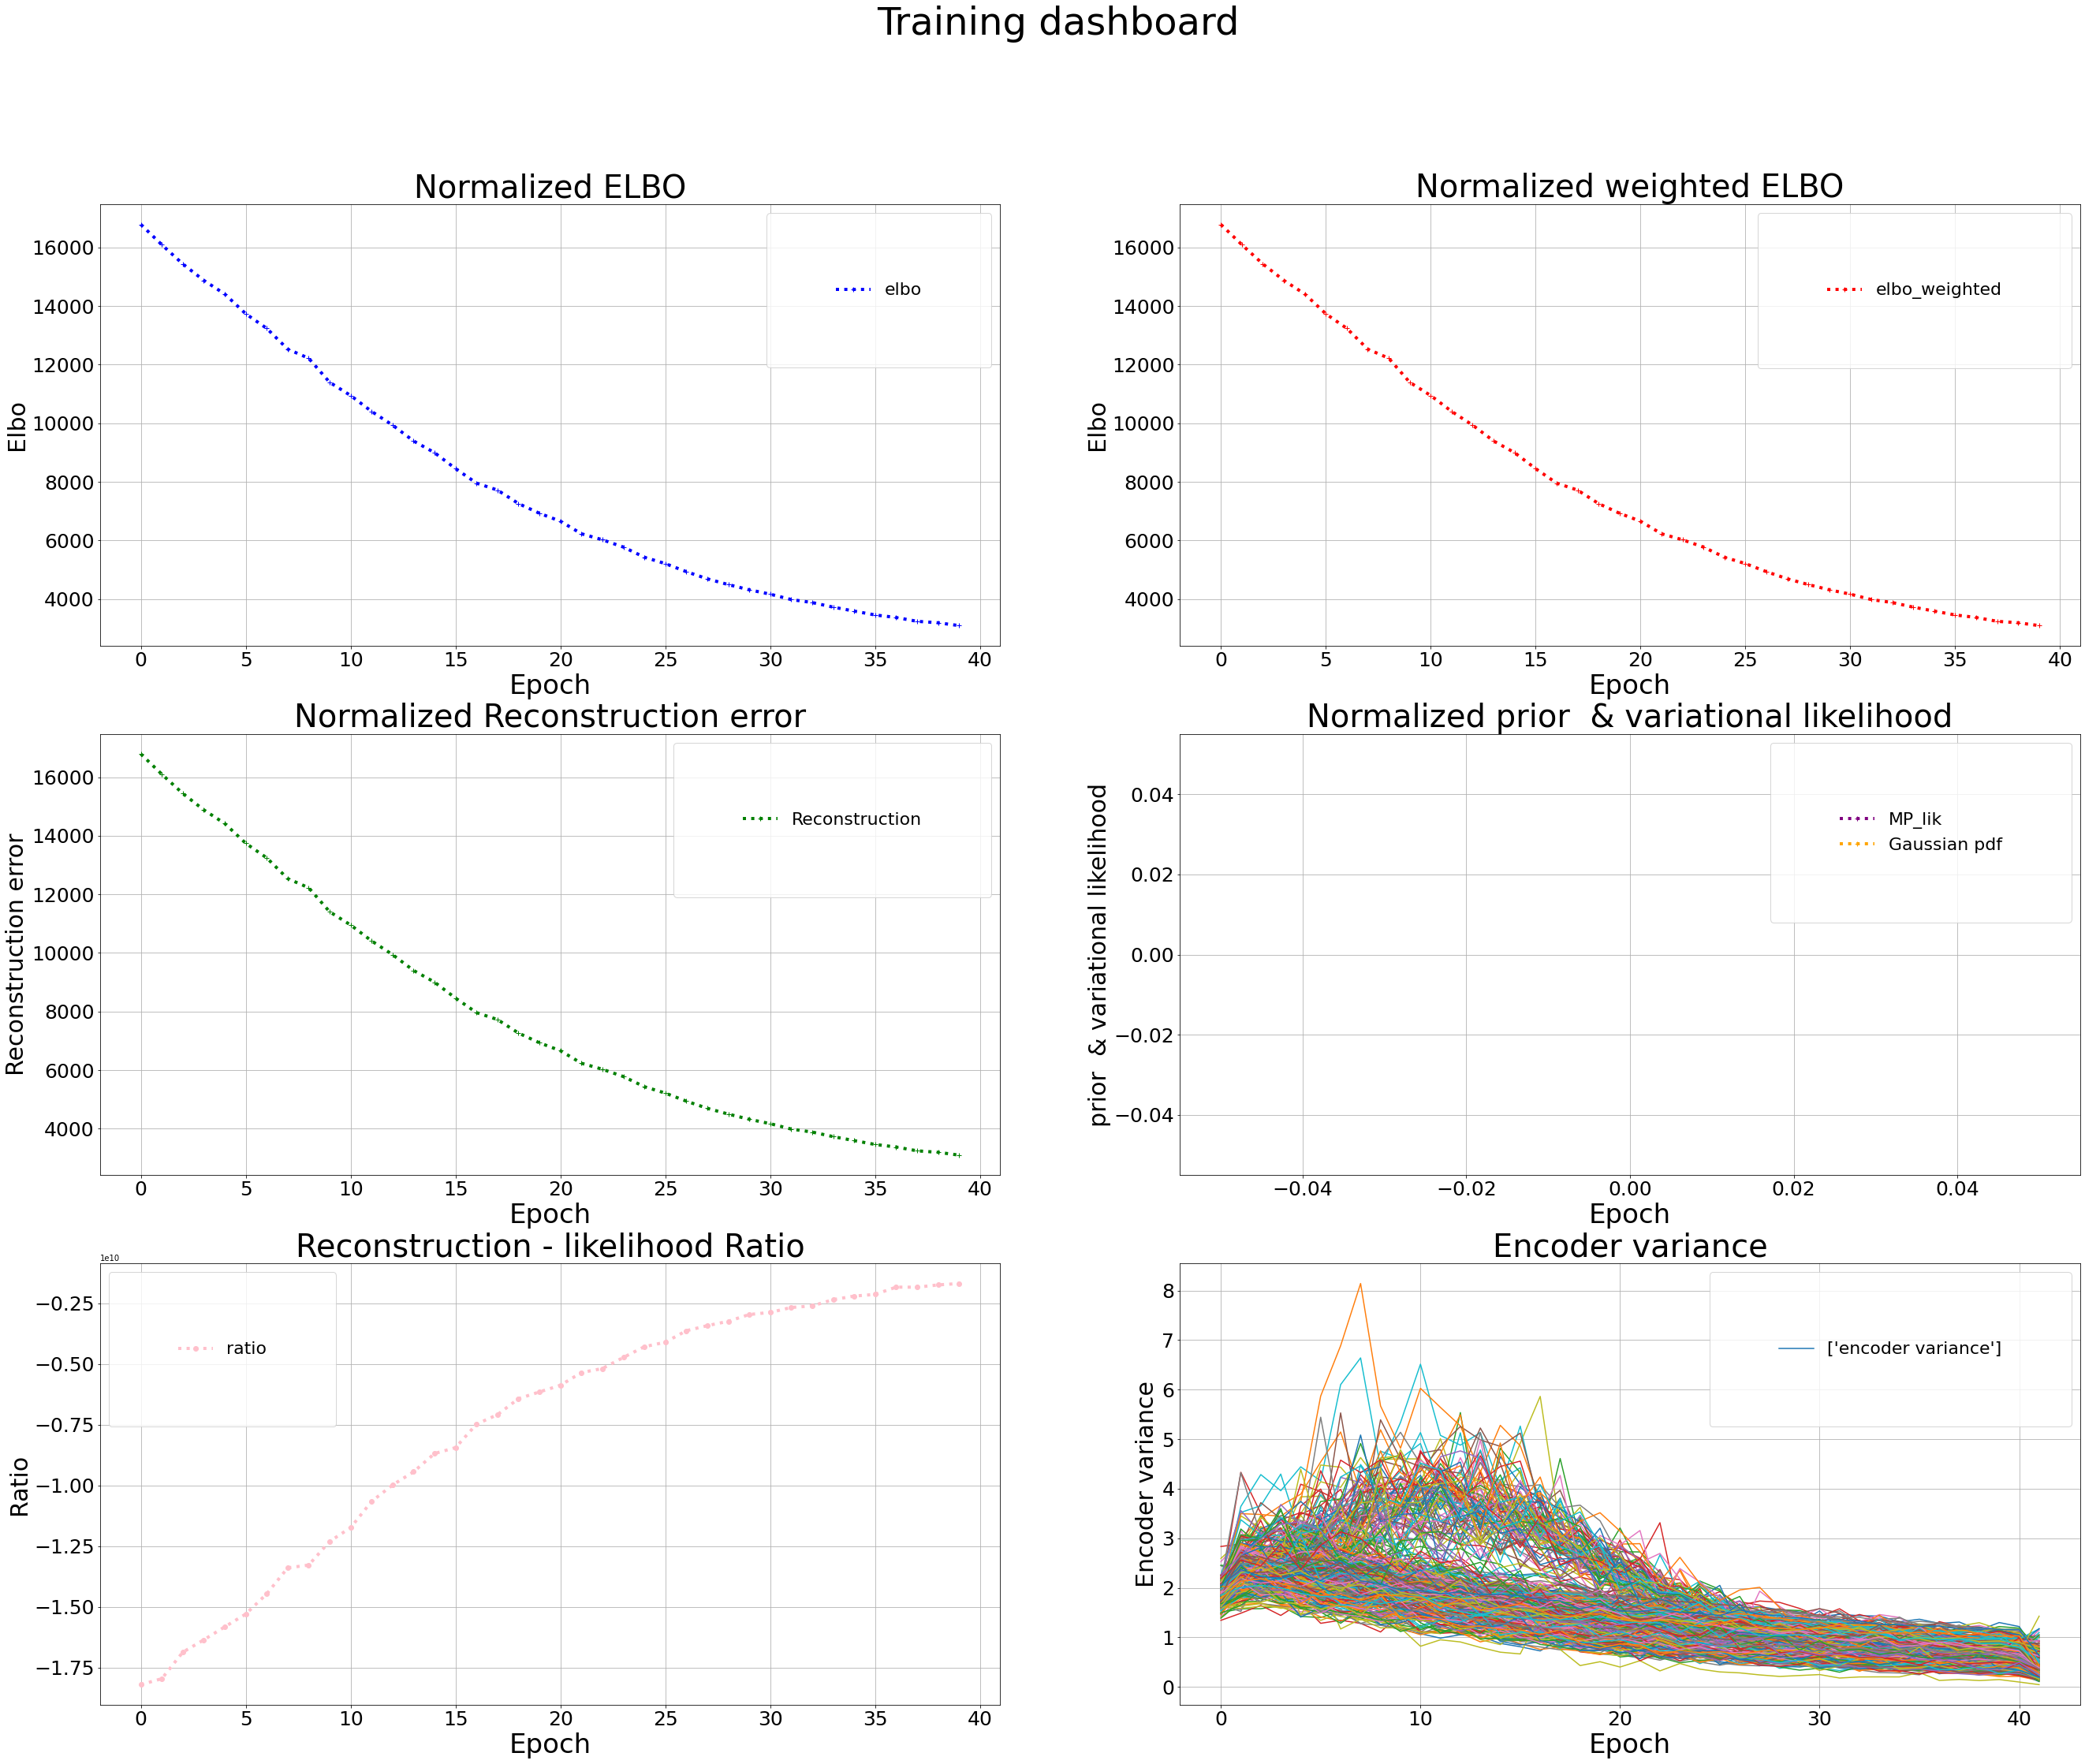

In [50]:
training_dashboard(trainer, vae.encoder_variance)

### 3. Posterior and MV imputation

In [ ]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset))
                                         )

***Missing Value imputation By Posterior Predictive sampling***

In [ ]:
empirical_l = np.mean(np.sum(glm.X, axis=1))

# CascVI impitations
imputed = {}
imputed_z = {}
imputed_gt = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], imputed_z[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l
                                                           )
        imputed_gt[n.name] = glm.X[n.index]

In [ ]:
imputed_X = [x for x in imputed.values()]
imputed_X = np.array(imputed_X).reshape(-1, cas_dataset.X.shape[1])
#plot_histograms(imputed_X, "Histogram of CasscVI imputed gene expression data")

***CascVI Baseline 1 (Average of reconstructions)***

In [ ]:
imputed_cascvi_1 = scvi_baseline(tree, full_posterior, True)

***CascVI Baseline 2 (Reconstruction of Averaged latent space)***

In [ ]:
imputed_cascvi_2, imputed_cascvi_2_z = scvi_baseline_z(tree=tree,
                                   model=vae,
                                   posterior=full_posterior,
                                   weighted=True,
                                   n_samples_z=1,
                                   library_size=empirical_l
                                  )

# 4. Baselines

***Baseline 1: Unweighted Average of gene expression in Clade***

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

In [ ]:
weighted = True
imputed_avg = avg_weighted_baseline(tree, True, glm.X, rounding=True)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, tree)
#plot_histograms(avg_X,
#               'Histograms of imputed GE values with the average baseline')

***Baseline 2: (Un)weighted Average of decoded latent vectors, with scVI***

We use the same averaging of the subtrees leaves in **Baseline 1**, only this time, the gene expression data is recovered with scVI

In [ ]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

In [ ]:
import torch

n_epochs = 400

vae_scvi = VAE(gene_dataset.nb_genes,
                  n_batch=cas_dataset.n_batches * use_batches,
                  n_hidden=128,
                  n_layers=1,
                  reconstruction_loss='poisson',
                  n_latent=glm.latent,
                  ldvae=True
              )


new_weight = torch.from_numpy(glm.W.T).float()
new_bias = torch.from_numpy(glm.beta).float()

with torch.no_grad():
    vae_scvi.decoder.factor_regressor.fc_layers[0][0].weight = torch.nn.Parameter(new_weight)
    vae_scvi.decoder.factor_regressor.fc_layers[0][0].bias = torch.nn.Parameter(new_bias)
    
for param in vae_scvi.decoder.factor_regressor.fc_layers[0][0].parameters():
    param.requires_grad = False
    

In [ ]:
trainer_scvi = UnsupervisedTrainer(model=vae_scvi,
                              gene_dataset=gene_dataset,
                              train_size=1.0,
                              use_cuda=use_cuda,
                              frequency=10,
                              n_epochs_kl_warmup=None)

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 
                                        
elbo_train_scvi = trainer_scvi.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3
        )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

***scVI Baseline 1 (Average of reconstructions)***

In [ ]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=gene_dataset
                                              )

imputed_scvi, imputed_scvi_z = scvi_baseline(tree=tree, 
                                             posterior=scvi_posterior, 
                                             weighted=True,
                                            give_latent=True,
                                            n_samples_z=1)

scvi_latent = scvi_posterior.get_latent()[0]
scvi_latent.shape

***scVI Baseline 2 (Decoded Average Latent space)***

In [ ]:
library_size = np.mean(np.sum(glm.X, axis=1))
imputed_scvi_2, imputed_scvi_2_z = scvi_baseline_z(tree=tree,
                                 model=vae_scvi,
                                 posterior=scvi_posterior,
                                 weighted=True,
                                 n_samples_z=1,
                                 library_size=library_size
                                )


***CascVI Baseline 3***

In [ ]:
imputed_cascvi_3 = cascvi_baseline_z(tree=tree,
                                   model=vae_scvi,
                                   latent=imputed_z,
                                   library_size=library_size
                                  )

***(Bonus) MP Imputation with scVI latent space***

In [ ]:
empirical_l = library_size

# CascVI impitations
imputed_bis = {}
imputed_z_bis = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_bis[n.name], imputed_z_bis[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            other_posterior=scvi_posterior
                                                           )

# 5. Likelihood Ratio

In [ ]:
cascvi_latent = full_posterior.get_latent()[0]
scvi_latent = scvi_posterior.get_latent()[0]

scvi_latent.shape, cascvi_latent.shape

In [ ]:
vae.initialize_visit()
vae.initialize_messages(scvi_posterior.get_latent()[0], cas_dataset.barcodes, scvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), scvi_latent.shape[1], False)
mp_lik_scvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of scVI encodings: ", mp_lik_scvi.item())

In [ ]:
vae.initialize_visit()
vae.initialize_messages(full_posterior.get_latent()[0], cas_dataset.barcodes, cascvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), cascvi_latent.shape[1], False)
mp_lik_cascvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of cascVI encodings: ", mp_lik_cascvi.item())

In [ ]:
# Likelihood ratio
lambda_ = (mp_lik_cascvi - mp_lik_scvi)
print("Likelihood Ratio:", lambda_)

# 6. Latent Space Analysis

***Message Passing on "ground truth" latent space***

In [ ]:
from utils.baselines import construct_latent
#empirical_l = library_size

# CascVI impitations
#imputed_real = {}
#imputed_z_real = {}

#for n in tree.traverse('levelorder'):
#    if not n.is_leaf():
#        imputed_real[n.name], imputed_z_real[n.name] = full_posterior.imputation_internal(n.name,
#                                                            give_mean=False,
#                                                            library_size=empirical_l,
#                                                            known_latent=leaves_z
#                                                           )
#full_real_latent = construct_latent(tree, leaves_z, imputed_z_real)

#print("Real latent space")
#plot_common_ancestor(tree,
#                     full_real_latent,
#                     embedding='umap',
#                     give_labels=False
#                             )

In [ ]:
mu_real = np.clip(a=np.exp(full_real_latent @ glm.W + glm.beta),
                         a_min=0,
                         a_max=5000
                  )

X_real = np.asarray(np.random.poisson(mu_real), dtype=np.float64)
internal_X_real, _, _ = get_internal(X_real, mu_real, tree)
internal_X_real.shape

***CascVI***

In [ ]:
plot_common_ancestor(tree,
                     cascvi_latent,
                     embedding='umap',
                     give_labels=False
                             )

In [ ]:
# Merge internal nodes and leaves
full_cascvi_latent = construct_latent(tree, cascvi_latent, imputed_z)


print("CascVI latent space")
plot_common_ancestor(tree,
                     full_cascvi_latent,
                     embedding='umap',
                     give_labels=False
                             )



In [ ]:
full_cascvi_latent_2 = construct_latent(tree, cascvi_latent, imputed_cascvi_2_z)

print("CascVI + averaging latent space")
plot_common_ancestor(tree,
                     full_cascvi_latent_2,
                     embedding='umap',
                     give_labels=False
                             )

***scVI***

In [ ]:
# Merge internal nodes and leaves
full_scvi_latent = construct_latent(tree, scvi_latent, imputed_scvi_2_z)

print("scVI latent space")
plot_common_ancestor(tree,
                 full_scvi_latent,
                 embedding='umap',
                 give_labels=False
                    )

***scVI + Message Passing***

In [ ]:
# Merge internal nodes and leaves
full_scvi_latent_2 = construct_latent(tree, scvi_latent, imputed_z_bis)

print("scVI latent space + Message passing")
plot_common_ancestor(tree,
                 full_scvi_latent_2,
                 embedding='umap',
                 give_labels=False
                    )

***k-NN purity***

Leaves only

In [ ]:
print("Leaves Only")
scores = knn_purity(max_neighbors=50,
              data=[leaves_z, scvi_latent, cascvi_latent],
              plot=True)

Internal nodes only

In [ ]:
print("Internal nodes Only")
internal_z, internal_idx, internal_mu = get_internal(glm.z, glm.mu, tree)
internal_scvi_z, _, _ = get_internal(full_scvi_latent, glm.mu, tree)
internal_scvi_z_2, _, _ = get_internal(full_scvi_latent_2, glm.mu, tree)
internal_cascvi_z, _, _ = get_internal(full_cascvi_latent, glm.mu, tree)
internal_cascvi_z_2, _, _ = get_internal(full_cascvi_latent_2, glm.mu, tree)

scores = knn_purity(max_neighbors=50,
              data=[internal_z, internal_scvi_z, internal_scvi_z_2, internal_cascvi_z, internal_cascvi_z_2],
              plot=True
              )

Full tree

In [ ]:
print("Full tree")
scores = knn_purity(max_neighbors=50,
              data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
              plot=True)

***Stratified k-NN purity***

In [ ]:
for k in [2, 5, 10, 20, 35, 50]:
    print("For {} neighbors".format(k))
    if k == 10:
        min_depth = 3
    elif k == 20:
        min_depth = 4
    elif k == 35:
        min_depth = 6
    elif k == 50:
        min_depth = 7
    else:
        min_depth = 2
    scores = knn_purity_stratified(n_neighbors=k,
                                   tree=tree,
                                   data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
                                   min_depth=min_depth,
                                   plot=True)

# 7. Variance analysis

***Empirical Variance of observed***

In [ ]:
# Get empirical variance of the encoder
qz_v_norm = full_posterior.empirical_qz_v(
                                    n_samples=1000,
                                    norm=True)

In [ ]:
var_dict = {}
node_sizes = []

for i, n in enumerate(tree.traverse('levelorder')):
    if not n.is_leaf():
        # if n is an internal node, we get the variance from the prior
        z = full_posterior.get_latent(give_mean=False)[0]
        _, v_nu = vae.posterior_predictive_density(query_node=n.name, 
                                                  evidence=z) 
        
        var_dict[n.name] = str(np.around(a=v_nu,
                             decimals=4)
                              )
        node_sizes.append(np.around(a=v_nu,
                             decimals=4)
                         )
    else:
        idx = leaves_idx.index(n.index)
        # if n is a leaf, we get the variance from the encoder
        
        # variational distribution variance
        
        # Empirical variance
        var_dict[n.name] = str(np.around(a=qz_v_norm[idx],
                                 decimals=4)
                             )
        node_sizes.append(np.around(a=qz_v_norm[idx],
                                 decimals=4) 
                         )

In [ ]:
var_dict

***Plot variance***

In [ ]:
plot_one_gene(tree=tree, 
              X=imputed_X, 
              g=0, 
              node_sizes=[int(n*10000) for n in node_sizes], #+[1000]
              var='latent',
              size=1000,
              show_index=True,
              save_fig=True,
              figsize=(180, 100)
             )

print("CascVI: Imputations + Variance analysis")

# 7. Evaluation

***CPM Normalization (for sample-sample correlation)***

get imputations into an array

In [ ]:
internal_scvi_X = np.array([x for x in imputed_scvi.values()]).reshape(-1, glm.X.shape[1])
internal_scvi_X_2 = np.array([x for x in imputed_scvi_2.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X = np.array([x for x in imputed_cascvi_1.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_2 = np.array([x for x in imputed_cascvi_2.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_cascvi_3.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_real.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_3 = internal_X_real

internal_scvi_X.shape, internal_scvi_X_2.shape, internal_cascvi_X.shape, internal_cascvi_X_2.shape, internal_cascvi_X_3.shape

In [ ]:
from sklearn.preprocessing import normalize

norm_internal_X = sc.pp.normalize_total(AnnData(internal_X), target_sum=1e4, inplace=False)['X'] 
norm_scvi_X = sc.pp.normalize_total(AnnData(internal_scvi_X), target_sum=1e4, inplace=False)['X']
norm_scvi_X_2 = sc.pp.normalize_total(AnnData(internal_scvi_X_2), target_sum=1e4, inplace=False)['X']
norm_avg_X = sc.pp.normalize_total(AnnData(internal_avg_X), target_sum=1e4, inplace=False)['X']
norm_imputed_X = sc.pp.normalize_total(AnnData(imputed_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X = sc.pp.normalize_total(AnnData(internal_cascvi_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_2 = sc.pp.normalize_total(AnnData(internal_cascvi_X_2), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_3 = sc.pp.normalize_total(AnnData(internal_cascvi_X_3), target_sum=1e4, inplace=False)['X']

norm_internal_X.shape

## I. Sample-Sample Correlations

***1. Sample-Sample correlation (Without Normalization)***

We will use Scipy to compute a nonparametric rank correlation between the imputed and the groundtruth profiles. The correlation is based on the Spearman Correlation Coefficient.

In [ ]:
data = [internal_X.T, imputed_X.T, internal_avg_X.T ,internal_scvi_X.T,
        internal_scvi_X_2.T, internal_cascvi_X.T, internal_cascvi_X_2.T, internal_cascvi_X_3.T]
df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

***2. Sample-Sample correlation (With ScanPy Normalization)***

In [ ]:
data = [norm_internal_X.T, norm_imputed_X.T, norm_avg_X.T ,norm_scvi_X.T,
        norm_scvi_X_2.T, norm_cascvi_X.T, norm_cascvi_X_2.T, norm_cascvi_X_3.T]
df2 = correlations(data, 'None', True)
df2.head(5)
plt.show()


## II. Gene-Gene Correlations

***1. Gene-Gene correlation (without Normalization)***

In [ ]:
data = [internal_X, imputed_X, internal_avg_X ,internal_scvi_X,
        internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2, norm_cascvi_X_3]
df3 = correlations(data, 'None', True)
df3.head(5)
plt.show()

***2. Gene-Gene correlation (With Normalization)***

In [ ]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3]

df4 = correlations(data, 'None', True)
df4.head(5)
plt.show()

***3. Gene-Gene correlation (With Rank Normalization)***

In [ ]:
data = [internal_X, imputed_X, internal_avg_X ,
        internal_scvi_X, internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3
       ]

df5 = correlations(data, 'rank', True)
df5.head(5)
plt.show()

***4. Gene-Gene correlation (With ScanPy + Rank Normalization)***

In [ ]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, norm_cascvi_X_2, norm_cascvi_X_3]
df = correlations(data, 'rank', True)
df.head(5)
plt.show()

### III. Table Summary

In [ ]:
columns = ["Method", "Spearman CC", "Pearson CC", "Kendall Tau"]
data = [df1, df2, df3, df4, df5]

tables = [[] for i in range(len(data))]

#task = ["Sample-Sample (None)", "Sample-Sample (CPM)", "Gene-Gene (None)", 
           #"Gene-Gene(CPM)", "Gene-Gene (Rank)" ]

for (df, t) in zip(data, tables):
    for m in np.unique(df.Method):
        sub_df = np.round(df[df['Method'] == m].mean(), decimals=3)
        t.append([m, sub_df['Spearman CC'], sub_df['Pearson CC'], sub_df['Pearson CC']])
        
# Create and style Data Frames
df_table1 = pd.DataFrame(tables[0], columns=columns)
df_table2 = pd.DataFrame(tables[1], columns=columns)
df_table3 = pd.DataFrame(tables[2], columns=columns)
df_table4 = pd.DataFrame(tables[3], columns=columns)
df_table5 = pd.DataFrame(tables[4], columns=columns)

In [ ]:
print(" >>> Sample-Sample | No Normalization <<<")
df_table1.head(10)

In [ ]:
print(">>> Sample-Sample | CPM Normalization <<<")
df_table2.head(10)

In [ ]:
print(">>> Gene-Gene | No Normalization <<<")
df_table3.head(10)

In [ ]:
print(">>> Gene-Gene | CPM Normalization <<<")
df_table4.head(10)

In [ ]:
print(">>> Gene-Gene | Rank Normalization <<<")
df_table5.head(10)

# 8. Exploratory grapghical analysis

***Box plot (Samples)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 300), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[k]), np.log(1 + norm_imputed_X[k]),
          np.log(1 + norm_avg_X[k]), np.log(1 + norm_scvi_X[k]),
           np.log(1 + norm_cascvi_X[k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Sample ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Box plot (Genes)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 1000), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[:, k]), np.log(1 + norm_imputed_X[:, k]),
          np.log(1 + norm_avg_X[:, k]), np.log(1 + norm_scvi_X[:, k]),
           np.log(1 + norm_cascvi_X[:, k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Density plots***

In [ ]:
import random
import seaborn as sns

n_samples = 12
idx = random.sample(range(1, 1000), n_samples)
n_rows = 3
n_cols = int(n_samples / n_rows)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(35, 15))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # density plots
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_imputed_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='cascVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_internal_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='groundtruth')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_scvi_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg scVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_avg_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_cascvi_X[:, k]), hist=False,
             kde=True, kde_kws={'shade': True}, label='Avg cascVI')
        # set title
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Combined gene density plots")
plt.show()